## Import libraries

In [1]:
import numpy as np 
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil 
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models

# in case CUDA is not available, shutdown notebook and reload GPU in terminal:
#     sudo rmmod nvidia_uvm
#     sudo modprobe nvidia_uvm

## Extract data

In [2]:
print(os.listdir('input'),'\n') 
with zipfile.ZipFile('input/platesv2/plates.zip', 'r') as zip_obj:
        zip_obj.extractall('img/') 
print(os.listdir('img/'))

data_root = 'img/plates/' 
print(data_root)
print(os.listdir(data_root))

['platesv2'] 

['__MACOSX', 'plates']
img/plates/
['test', '.DS_Store', 'train']


## Split data into train and val

In [3]:
train_dir = 'train' # на этих данных будем обучать модель
val_dir = 'val' #на этих данных будем смотреть какую accuracy показывает наша модель 
class_names = ['cleaned', 'dirty']
 
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
 
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3047.34it/s]


## Data processing

In [4]:
train_transforms_base = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms_rotate_augment = transforms.Compose([
    transforms.ColorJitter(hue=(-0.5,-0.3)),
    transforms.RandomRotation(degrees = 150),
    transforms.RandomResizedCrop(224, scale=(0.65, 0.9), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transforms_flip_augment = transforms.Compose([
    transforms.ColorJitter(hue=(-0.5,-0.3)),
    transforms.RandomResizedCrop(224, scale=(0.65, 0.9), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees = 150),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset_base = torchvision.datasets.ImageFolder(train_dir, train_transforms_base)
train_dataset_rotated = torchvision.datasets.ImageFolder(train_dir, train_transforms_rotate_augment)
train_dataset_flipped = torchvision.datasets.ImageFolder(train_dir, train_transforms_flip_augment)
val_dataset_base = torchvision.datasets.ImageFolder(val_dir, val_transforms_base)
val_dataset_augmented = torchvision.datasets.ImageFolder(val_dir, val_transforms_augmented)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_base, train_dataset_rotated, train_dataset_flipped])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_base])


batch_size = 16 # Количество изображений в батче
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

## Output images

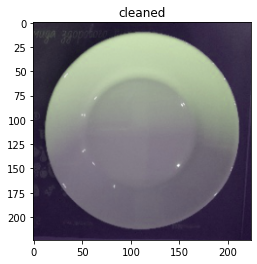

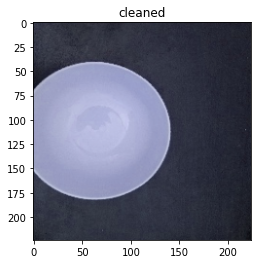

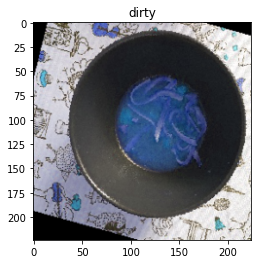

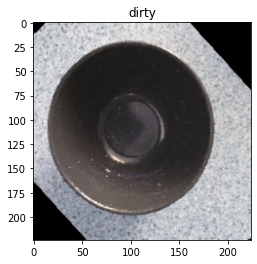

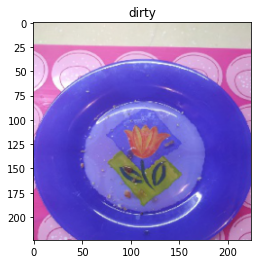

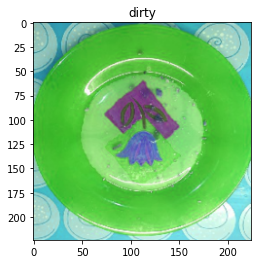

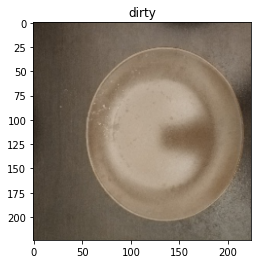

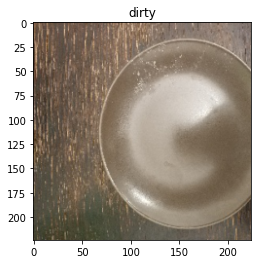

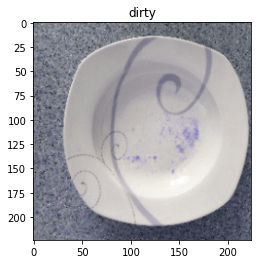

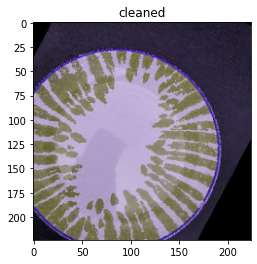

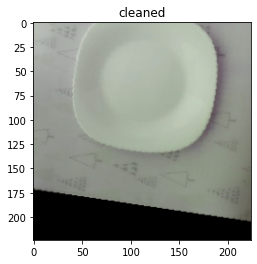

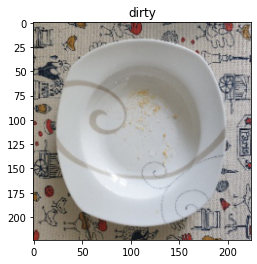

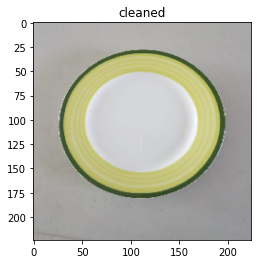

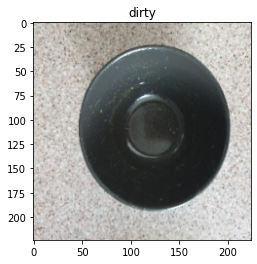

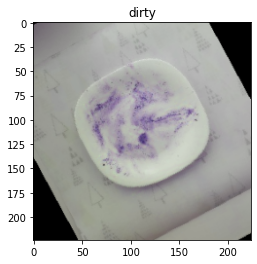

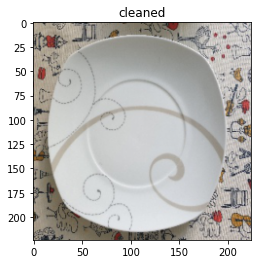

In [5]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() #обратная операция к ToTensor - .permute(1, 2, 0) Channels,H,W -> H,W,Channels потом превращаем в numpy array .numpy()
    image = std * image + mean #Делаем обратную трансформацию нормировки
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)
 
X_batch, y_batch = next(iter(train_dataloader)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## Function to train the network

In [1]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
 
    for epoch in range(num_epochs):
        print("\n Epoch {}/{}:".format(epoch, num_epochs - 1), end="")
        for phase in ['train', 'val']:
            if phase == 'train': #Если фаза == Тренировки  
                dataloader = train_dataloader #берем train_dataLoader
                #scheduler.step() #Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: #Если фаза == Валидации 
                dataloader = val_dataloader #берем val_dataLoader 
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): #Если фаза train то активируем все градиенты (те которые не заморожены) (очистить историю loss)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) #Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс,берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() #считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  #считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) #считаем Loss на кол-во бачей в эпохе
 
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc), end="")
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
            if phase == 'train':
                scheduler.step()
        
    return model, loss_hist, acc_hist

## Network settings and parameters

In [2]:
model = models.resnet18(pretrained=True) #Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этого ResNet, на датасете ImageNet
          
# Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой
for param in model.parameters(): #Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
   param.requires_grad = False #Для каждого параметра и слоя:"requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать.
    
#Меняем последний полносвязанный слой, в ResNet он классифицирует на тысячу классов, а у нас класса всего 2.
model.fc = torch.nn.Linear(model.fc.in_features, 2) # Cоздадим слой torch.nn.Linear, это полносвязный слой, на вход он принимает model fc_in features. И он единсвенный - разморожен.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Network will be trained on {device} device")
model = model.to(device)
 
#Определяем Loss функцию
#В данном случае - это бинарная кросс-энтропия CrossEntropyLoss (у нас всего 2 класса) 
loss = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска Adam
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.01) #lr - (learning rate - шаг градиентного спуска)
# Уменьшаем шаг градиентного спуска каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

NameError: name 'models' is not defined

## Network training

In [8]:
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=100);
#Запуск функции Train (Модель= ResNet,Loss-функция= CrossEntropyLoss(бинарная кросс-энтропия),Метод градиентного спуска= Adam, Уменьшение градиентного спуска в зависимости от кол-ва эпох, Кол-во эпох= 30) )

/home/nick/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



 Epoch 0/99:

100%|██████████| 6/6 [00:01<00:00,  4.89it/s]


train Loss: 1.4401 Acc: 0.5000

100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


val Loss: 2.9504 Acc: 0.5000
 Epoch 1/99:

100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


train Loss: 1.0408 Acc: 0.6146

100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


val Loss: 0.6489 Acc: 0.6250
 Epoch 2/99:

100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


train Loss: 0.3062 Acc: 0.8750

100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


val Loss: 0.9027 Acc: 0.5000
 Epoch 3/99:

100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


train Loss: 0.1684 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


val Loss: 0.6312 Acc: 0.5000
 Epoch 4/99:

100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


train Loss: 0.1929 Acc: 0.9062

100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


val Loss: 0.8200 Acc: 0.7500
 Epoch 5/99:

100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


train Loss: 0.1557 Acc: 0.9375

100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


val Loss: 0.6760 Acc: 0.6250
 Epoch 6/99:

100%|██████████| 6/6 [00:01<00:00,  4.75it/s]


train Loss: 0.1243 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


val Loss: 0.6855 Acc: 0.6250
 Epoch 7/99:

100%|██████████| 6/6 [00:01<00:00,  4.61it/s]


train Loss: 0.1575 Acc: 0.9375

100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


val Loss: 0.6872 Acc: 0.5000
 Epoch 8/99:

100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


train Loss: 0.1009 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


val Loss: 0.6954 Acc: 0.5000
 Epoch 9/99:

100%|██████████| 6/6 [00:01<00:00,  5.70it/s]


train Loss: 0.1318 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


val Loss: 0.6907 Acc: 0.5000
 Epoch 10/99:

100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


train Loss: 0.1908 Acc: 0.9167

100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


val Loss: 0.6916 Acc: 0.5000
 Epoch 11/99:

100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


train Loss: 0.1344 Acc: 0.9375

100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


val Loss: 0.6835 Acc: 0.5000
 Epoch 12/99:

100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


train Loss: 0.0820 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


val Loss: 0.6934 Acc: 0.5000
 Epoch 13/99:

100%|██████████| 6/6 [00:01<00:00,  5.58it/s]


train Loss: 0.1047 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


val Loss: 0.7067 Acc: 0.5000
 Epoch 14/99:

100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


train Loss: 0.1241 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


val Loss: 0.6909 Acc: 0.5000
 Epoch 15/99:

100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


train Loss: 0.1137 Acc: 0.9583

100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


val Loss: 0.6933 Acc: 0.5000
 Epoch 16/99:

100%|██████████| 6/6 [00:01<00:00,  5.41it/s]


train Loss: 0.1794 Acc: 0.9167

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


val Loss: 0.7120 Acc: 0.5000
 Epoch 17/99:

100%|██████████| 6/6 [00:01<00:00,  5.49it/s]


train Loss: 0.1099 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


val Loss: 0.6896 Acc: 0.5000
 Epoch 18/99:

100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


train Loss: 0.0882 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


val Loss: 0.7045 Acc: 0.5000
 Epoch 19/99:

100%|██████████| 6/6 [00:01<00:00,  5.60it/s]


train Loss: 0.1002 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


val Loss: 0.6946 Acc: 0.5000
 Epoch 20/99:

100%|██████████| 6/6 [00:01<00:00,  5.68it/s]


train Loss: 0.0759 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


val Loss: 0.6890 Acc: 0.5000
 Epoch 21/99:

100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


train Loss: 0.1050 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


val Loss: 0.6829 Acc: 0.5000
 Epoch 22/99:

100%|██████████| 6/6 [00:01<00:00,  5.30it/s]


train Loss: 0.1074 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


val Loss: 0.6879 Acc: 0.5000
 Epoch 23/99:

100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


train Loss: 0.0961 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


val Loss: 0.6830 Acc: 0.5000
 Epoch 24/99:

100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


train Loss: 0.1003 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


val Loss: 0.6815 Acc: 0.5000
 Epoch 25/99:

100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


train Loss: 0.1132 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


val Loss: 0.6864 Acc: 0.5000
 Epoch 26/99:

100%|██████████| 6/6 [00:01<00:00,  5.44it/s]


train Loss: 0.1067 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


val Loss: 0.6971 Acc: 0.5000
 Epoch 27/99:

100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


train Loss: 0.1048 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


val Loss: 0.6989 Acc: 0.5000
 Epoch 28/99:

100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


train Loss: 0.1001 Acc: 0.9583

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


val Loss: 0.6867 Acc: 0.6250
 Epoch 29/99:

100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


train Loss: 0.1069 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


val Loss: 0.6806 Acc: 0.5000
 Epoch 30/99:

100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


train Loss: 0.0945 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


val Loss: 0.6661 Acc: 0.5000
 Epoch 31/99:

100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


train Loss: 0.1012 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


val Loss: 0.6740 Acc: 0.5000
 Epoch 32/99:

100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


train Loss: 0.1494 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


val Loss: 0.6835 Acc: 0.5000
 Epoch 33/99:

100%|██████████| 6/6 [00:01<00:00,  4.91it/s]


train Loss: 0.0920 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


val Loss: 0.6973 Acc: 0.5000
 Epoch 34/99:

100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


train Loss: 0.1165 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


val Loss: 0.6777 Acc: 0.5000
 Epoch 35/99:

100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


train Loss: 0.1018 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


val Loss: 0.6880 Acc: 0.5000
 Epoch 36/99:

100%|██████████| 6/6 [00:01<00:00,  5.24it/s]


train Loss: 0.1423 Acc: 0.9583

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


val Loss: 0.6901 Acc: 0.5000
 Epoch 37/99:

100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


train Loss: 0.1690 Acc: 0.9375

100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


val Loss: 0.7012 Acc: 0.5000
 Epoch 38/99:

100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


train Loss: 0.1044 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


val Loss: 0.7033 Acc: 0.5000
 Epoch 39/99:

100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


train Loss: 0.1324 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


val Loss: 0.6817 Acc: 0.5000
 Epoch 40/99:

100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


train Loss: 0.1054 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


val Loss: 0.6875 Acc: 0.5000
 Epoch 41/99:

100%|██████████| 6/6 [00:01<00:00,  5.43it/s]


train Loss: 0.0898 Acc: 1.0000

100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


val Loss: 0.6874 Acc: 0.5000
 Epoch 42/99:

100%|██████████| 6/6 [00:01<00:00,  5.35it/s]


train Loss: 0.1252 Acc: 0.9375

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


val Loss: 0.6875 Acc: 0.5000
 Epoch 43/99:

100%|██████████| 6/6 [00:01<00:00,  5.39it/s]


train Loss: 0.1025 Acc: 1.0000

100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


val Loss: 0.6779 Acc: 0.5000
 Epoch 44/99:

100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


train Loss: 0.1564 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


val Loss: 0.6711 Acc: 0.5000
 Epoch 45/99:

100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


train Loss: 0.1011 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


val Loss: 0.6715 Acc: 0.5000
 Epoch 46/99:

100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


train Loss: 0.1108 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


val Loss: 0.6721 Acc: 0.5000
 Epoch 47/99:

100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


train Loss: 0.2176 Acc: 0.8958

100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


val Loss: 0.6697 Acc: 0.5000
 Epoch 48/99:

100%|██████████| 6/6 [00:01<00:00,  5.32it/s]


train Loss: 0.0970 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


val Loss: 0.6677 Acc: 0.5000
 Epoch 49/99:

100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


train Loss: 0.1027 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


val Loss: 0.6795 Acc: 0.5000
 Epoch 50/99:

100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


train Loss: 0.1497 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


val Loss: 0.6825 Acc: 0.5000
 Epoch 51/99:

100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


train Loss: 0.1304 Acc: 0.9375

100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


val Loss: 0.7044 Acc: 0.5000
 Epoch 52/99:

100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


train Loss: 0.1398 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


val Loss: 0.6829 Acc: 0.5000
 Epoch 53/99:

100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


train Loss: 0.1200 Acc: 0.9583

100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


val Loss: 0.6700 Acc: 0.5000
 Epoch 54/99:

100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


train Loss: 0.0747 Acc: 1.0000

100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


val Loss: 0.6608 Acc: 0.5000
 Epoch 55/99:

100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


train Loss: 0.1077 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


val Loss: 0.6776 Acc: 0.5000
 Epoch 56/99:

100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


train Loss: 0.1050 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


val Loss: 0.6803 Acc: 0.5000
 Epoch 57/99:

100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


train Loss: 0.1584 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


val Loss: 0.6865 Acc: 0.5000
 Epoch 58/99:

100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


train Loss: 0.0824 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


val Loss: 0.6698 Acc: 0.5000
 Epoch 59/99:

100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


train Loss: 0.0740 Acc: 1.0000

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


val Loss: 0.6625 Acc: 0.5000
 Epoch 60/99:

100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


train Loss: 0.1237 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


val Loss: 0.6658 Acc: 0.5000
 Epoch 61/99:

100%|██████████| 6/6 [00:01<00:00,  5.26it/s]


train Loss: 0.1076 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


val Loss: 0.6682 Acc: 0.5000
 Epoch 62/99:

100%|██████████| 6/6 [00:01<00:00,  5.29it/s]


train Loss: 0.1205 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


val Loss: 0.6665 Acc: 0.6250
 Epoch 63/99:

100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


train Loss: 0.1318 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


val Loss: 0.6683 Acc: 0.5000
 Epoch 64/99:

100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


train Loss: 0.1049 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


val Loss: 0.6871 Acc: 0.5000
 Epoch 65/99:

100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


train Loss: 0.1099 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


val Loss: 0.7101 Acc: 0.5000
 Epoch 66/99:

100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


train Loss: 0.1119 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


val Loss: 0.7008 Acc: 0.5000
 Epoch 67/99:

100%|██████████| 6/6 [00:01<00:00,  5.04it/s]


train Loss: 0.1159 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


val Loss: 0.6909 Acc: 0.5000
 Epoch 68/99:

100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


train Loss: 0.0776 Acc: 1.0000

100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


val Loss: 0.6954 Acc: 0.5000
 Epoch 69/99:

100%|██████████| 6/6 [00:01<00:00,  4.41it/s]


train Loss: 0.0818 Acc: 1.0000

100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


val Loss: 0.6755 Acc: 0.5000
 Epoch 70/99:

100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


train Loss: 0.0908 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


val Loss: 0.6804 Acc: 0.5000
 Epoch 71/99:

100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


train Loss: 0.1825 Acc: 0.9375

100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


val Loss: 0.6846 Acc: 0.5000
 Epoch 72/99:

100%|██████████| 6/6 [00:01<00:00,  5.16it/s]


train Loss: 0.1054 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


val Loss: 0.6830 Acc: 0.5000
 Epoch 73/99:

100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


train Loss: 0.0773 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


val Loss: 0.6987 Acc: 0.5000
 Epoch 74/99:

100%|██████████| 6/6 [00:01<00:00,  5.25it/s]


train Loss: 0.1267 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


val Loss: 0.6986 Acc: 0.5000
 Epoch 75/99:

100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


train Loss: 0.1635 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


val Loss: 0.7041 Acc: 0.6250
 Epoch 76/99:

100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


train Loss: 0.1116 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


val Loss: 0.6945 Acc: 0.5000
 Epoch 77/99:

100%|██████████| 6/6 [00:01<00:00,  5.46it/s]


train Loss: 0.1287 Acc: 0.9479

100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


val Loss: 0.6832 Acc: 0.5000
 Epoch 78/99:

100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


train Loss: 0.0879 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


val Loss: 0.6973 Acc: 0.5000
 Epoch 79/99:

100%|██████████| 6/6 [00:01<00:00,  5.34it/s]


train Loss: 0.0656 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


val Loss: 0.6860 Acc: 0.5000
 Epoch 80/99:

100%|██████████| 6/6 [00:01<00:00,  5.48it/s]


train Loss: 0.1142 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


val Loss: 0.6916 Acc: 0.5000
 Epoch 81/99:

100%|██████████| 6/6 [00:01<00:00,  5.33it/s]


train Loss: 0.0931 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


val Loss: 0.6915 Acc: 0.5000
 Epoch 82/99:

100%|██████████| 6/6 [00:01<00:00,  5.17it/s]


train Loss: 0.1460 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


val Loss: 0.6676 Acc: 0.5000
 Epoch 83/99:

100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


train Loss: 0.1756 Acc: 0.9375

100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


val Loss: 0.6930 Acc: 0.5000
 Epoch 84/99:

100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


train Loss: 0.0918 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


val Loss: 0.7028 Acc: 0.5000
 Epoch 85/99:

100%|██████████| 6/6 [00:01<00:00,  5.28it/s]


train Loss: 0.1160 Acc: 0.9583

100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


val Loss: 0.6852 Acc: 0.5000
 Epoch 86/99:

100%|██████████| 6/6 [00:01<00:00,  5.09it/s]


train Loss: 0.0800 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


val Loss: 0.6951 Acc: 0.5000
 Epoch 87/99:

100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


train Loss: 0.2080 Acc: 0.9167

100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


val Loss: 0.6941 Acc: 0.5000
 Epoch 88/99:

100%|██████████| 6/6 [00:01<00:00,  5.19it/s]


train Loss: 0.1021 Acc: 1.0000

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


val Loss: 0.6873 Acc: 0.5000
 Epoch 89/99:

100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


train Loss: 0.0682 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


val Loss: 0.6852 Acc: 0.5000
 Epoch 90/99:

100%|██████████| 6/6 [00:01<00:00,  5.05it/s]


train Loss: 0.1494 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


val Loss: 0.6831 Acc: 0.5000
 Epoch 91/99:

100%|██████████| 6/6 [00:01<00:00,  5.08it/s]


train Loss: 0.1023 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


val Loss: 0.6785 Acc: 0.5000
 Epoch 92/99:

100%|██████████| 6/6 [00:01<00:00,  5.22it/s]


train Loss: 0.1063 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


val Loss: 0.6847 Acc: 0.5000
 Epoch 93/99:

100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


train Loss: 0.0933 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


val Loss: 0.6880 Acc: 0.5000
 Epoch 94/99:

100%|██████████| 6/6 [00:01<00:00,  5.13it/s]


train Loss: 0.1130 Acc: 0.9688

100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


val Loss: 0.6908 Acc: 0.5000
 Epoch 95/99:

100%|██████████| 6/6 [00:01<00:00,  5.23it/s]


train Loss: 0.0874 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


val Loss: 0.6861 Acc: 0.5000
 Epoch 96/99:

100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


train Loss: 0.1007 Acc: 0.9896

100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


val Loss: 0.6816 Acc: 0.5000
 Epoch 97/99:

100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


train Loss: 0.0763 Acc: 1.0000

100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


val Loss: 0.6890 Acc: 0.5000
 Epoch 98/99:

100%|██████████| 6/6 [00:01<00:00,  5.01it/s]


train Loss: 0.1095 Acc: 0.9792

100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


val Loss: 0.6896 Acc: 0.5000
 Epoch 99/99:

100%|██████████| 6/6 [00:01<00:00,  5.37it/s]


train Loss: 0.1450 Acc: 0.9375

100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

val Loss: 0.6870 Acc: 0.6250

## Accuracy plots

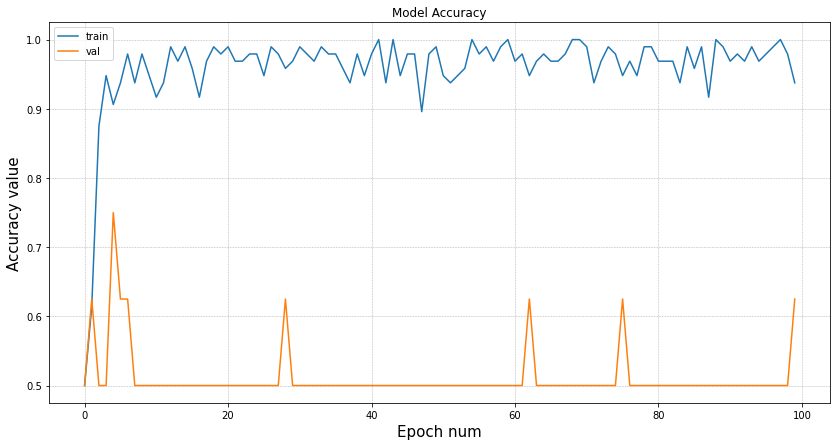

In [9]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

## Loss plots

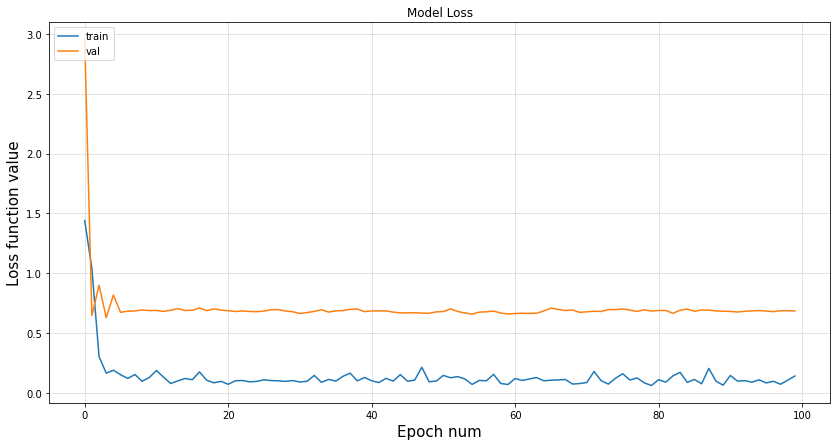

In [10]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [11]:
#Костыль ImageFolder, который не может обработать путь к папке в которой уже сразу лежат изображения
#Копируем всю папку test в директорию test\unknown
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

FileExistsError: [Errno 17] File exists: 'test/unknown'

In [ ]:
#Мы не знаем, какие ID, какие названия изображения у нас генерируется, когда мы просим у DataLoader -- "дай нам следующий батч".
#Они по алфавиту идут, по дате создания, или просто случайным образом -- непонятно.
#Поэтому нам нужно переписать немножко ImageFolder, чтобы он нам отдавал не просто tuple, с самим изображением и его меткой, а ещё, чтобы он отдавал имя, ну, либо -- путь к изображению.
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('test/', val_transforms_base)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.725 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

## Save submission

In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val